# Image Analysis with Video Object Detection 

This notebook is a **clear, end‑to‑end example** of the *Video Data Analysis Roadmap* applied to **object detection** on videos.
It uses **OpenCV** to decode frames and **torchvision’s Faster R‑CNN (COCO pretrained)** to detect objects per frame.

**You’ll find:** explanations before each code cell, analysis after each step, exercises, and a results table template.

> Tip: Start with a **short clip (≤30s)** while you iterate. Later, scale up and measure throughput.

## What we’ll do
1) Setup & Config → paths, sampling, thresholds  
2) Imports, Device & Reproducibility  
3) Video Probing → fps, duration, resolution, codec  
4) Frame Sampling → decode frames at stride S, manifest  
5) Transforms → preprocessing to tensors  
6) Model → Faster R‑CNN (COCO), score threshold  
7) Inference on Frames → batch detection, timings  
8) Visualization → draw boxes/labels; save annotated video  
9) Results & Diagnostics → summary stats and guidance  
10) Summary & Next Steps

### 1) Setup & Config 
All experiment knobs live here. Edit paths, sampling, and thresholds without touching later cells.

In [1]:
VIDEO_PATH = 'sample.mp4'
OUT_VIDEO  = 'annotated_output.mp4'
FRAME_STRIDE = 5
MAX_FRAMES   = 500
BATCH_SIZE   = 4
SCORE_THRESH = 0.5
NMS_IOU      = 0.5
RANDOM_SEED  = 42

**Analysis**
- Sampling trade‑off: larger stride → faster but may miss events.
- Score threshold: higher → precision↑, recall↓.
- Batch size: limited by GPU memory; detectors are heavy.

**Exercise:** Define a success criterion and pick two (stride, threshold) settings to compare.

### 2) Imports, Device & Reproducibility 

In [2]:
import os, math, time, random, json, pathlib
from typing import List

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Device: cuda


**Analysis**
- Expect cuda on GPU machines; CPU works but slower.
- Determinism slightly reduces speed; acceptable for teaching.

**Exercise:** If on CPU, set MAX_FRAMES=200 and BATCH_SIZE=2.

### 3) Probe Video - *fps, duration, resolution*

In [4]:
assert os.path.exists(VIDEO_PATH), f'Video not found: {VIDEO_PATH}'
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f'Could not open video: {VIDEO_PATH}'
fps = cap.get(cv2.CAP_PROP_FPS) or 0
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 0
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 0
duration_s = num_frames / fps if fps > 0 else 0.0
print(f'FPS: {fps:.2f} | Frames: {num_frames} | Resolution: {width}x{height} | Duration: {duration_s:.2f}s')

FPS: 25.00 | Frames: 341 | Resolution: 1920x1080 | Duration: 13.64s


**Analysis**
- Validate fps/resolution; odd values may signal VFR or corruption.

**Exercise:** Estimate #processed frames with your stride and max cap.

### 4) Frame Sampling

In [5]:
def sample_frames(cap, stride, max_frames):
    frames = []
    idx = 0; kept = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    while True:
        ok, frame_bgr = cap.read()
        if not ok: break
        if idx % stride == 0:
            frames.append(frame_bgr)
            kept += 1
            if kept >= max_frames:
                break
        idx += 1
    return frames

frames_bgr = sample_frames(cap, FRAME_STRIDE, MAX_FRAMES)
cap.release()
print('Kept', len(frames_bgr), 'frames; example shape:', frames_bgr[0].shape)

Kept 69 frames; example shape: (1080, 1920, 3)


**Analysis**
- Keep frame count manageable first; scale up later.

**Exercise:** Try stride=2 and stride=8; record kept frames.

### 5) Preprocessing for Detector - *BGR→RGB, to tensor*

In [6]:
from torchvision import transforms
to_tensor = transforms.Compose([
    transforms.ToTensor()
])

def bgr_to_rgb(img_bgr):
    import cv2
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rgb0 = bgr_to_rgb(frames_bgr[0])
print('RGB sample shape:', rgb0.shape)

RGB sample shape: (1080, 1920, 3)


**Analysis**
- Ensure RGB ordering; wrong channels harm accuracy.

**Exercise:** Visualize BGR vs RGB with imshow to see the difference.

### 6) Model - Faster R‑CNN (COCO pretrained)

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model = model.to(device).eval()
print('Model ready.')

Model ready.


**Analysis**
- Trained on COCO (80 classes); domain shift may reduce accuracy.

**Exercise:** Name 3 classes you expect here.

### 7) Inference on Frames 

In [8]:
import time, torch

def run_detector_on_frames(frames_bgr, batch_size=4, score_thresh=0.5):
    detections = []
    t0 = time.time()
    tensors = [to_tensor(bgr_to_rgb(f)) for f in frames_bgr]
    with torch.no_grad():
        for i in range(0, len(tensors), batch_size):
            batch = [t.to(device) for t in tensors[i:i+batch_size]]
            outputs = model(batch)
            for out in outputs:
                keep = out['scores'] >= score_thresh
                detections.append({
                    'boxes': out['boxes'][keep].detach().cpu().numpy(),
                    'labels': out['labels'][keep].detach().cpu().numpy(),
                    'scores': out['scores'][keep].detach().cpu().numpy(),
                })
    elapsed = time.time() - t0
    return detections, elapsed

dets, infer_time = run_detector_on_frames(frames_bgr, BATCH_SIZE, SCORE_THRESH)
fps_proc = len(frames_bgr)/infer_time if infer_time>0 else 0
print(f'Inference: {infer_time:.2f}s, {fps_proc:.2f} FPS processed')

Inference: 20.87s, 3.31 FPS processed


**Analysis**
- Track processed FPS; adjust stride/batch for speed.
- Tune threshold for precision/recall trade‑off.

**Exercise:** Try thresholds 0.3 and 0.7; compare outputs qualitatively.

### 8) Visualization & Export

In [11]:
import cv2

def draw_boxes_on_frame(frame_bgr, boxes, labels, scores):
    frame = frame_bgr.copy()
    for (x1,y1,x2,y2), lab, sc in zip(boxes, labels, scores):
        color = (0,0,255)
        cv2.rectangle(frame, (int(x1),int(y1)), (int(x2),int(y2)), color, 2)
        name = COCO_INSTANCE_CATEGORY_NAMES[int(lab)] if int(lab) < len(COCO_INSTANCE_CATEGORY_NAMES) else str(int(lab))
        cv2.putText(frame, f'{name}:{sc:.2f}', (int(x1), max(0,int(y1)-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    return frame

# writer
cap2 = cv2.VideoCapture(VIDEO_PATH)
fps2 = cap2.get(cv2.CAP_PROP_FPS) or 24
w2  = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH)) or 640
h2  = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 360
cap2.release()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(OUT_VIDEO, fourcc, fps2, (w2, h2))

for f_bgr, det in zip(frames_bgr, dets):
    frame_anno = draw_boxes_on_frame(f_bgr, det['boxes'], det['labels'], det['scores'])
    if frame_anno.shape[1] != w2 or frame_anno.shape[0] != h2:
        frame_anno = cv2.resize(frame_anno, (w2, h2))
    writer.write(frame_anno)
writer.release()
print('Annotated video saved to:', OUT_VIDEO)

Annotated video saved to: annotated_output.mp4


**Analysis**
- Confirm boxes align with objects; misalignment suggests preprocessing/resize issues.

**Exercise:** Modify drawing to only show `person` detections.

### 9) Results

Total frames: 69
Total detections: 3166
Top classes: [('person', 2750), ('handbag', 204), ('skis', 148), ('sports ball', 19), ('wine glass', 15), ('fork', 12), ('baseball bat', 11), ('horse', 4), ('cat', 3)]


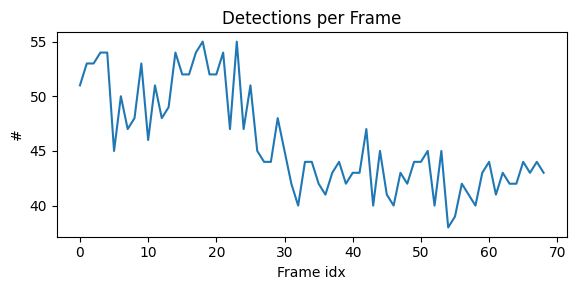

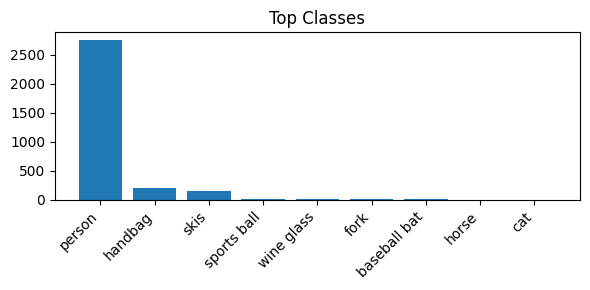

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

cls_counter = Counter()
boxes_per_frame = []
for det in dets:
    labs = det['labels'].tolist()
    boxes_per_frame.append(len(labs))
    for l in labs:
        name = COCO_INSTANCE_CATEGORY_NAMES[int(l)] if int(l) < len(COCO_INSTANCE_CATEGORY_NAMES) else str(int(l))
        cls_counter[name] += 1

print('Total frames:', len(dets))
print('Total detections:', sum(boxes_per_frame))
print('Top classes:', cls_counter.most_common(10))

plt.figure(figsize=(6,3)); plt.plot(boxes_per_frame); plt.title('Detections per Frame'); plt.xlabel('Frame idx'); plt.ylabel('#'); plt.tight_layout(); plt.show()

names = [k for k,_ in cls_counter.most_common(10)]
vals  = [v for _,v in cls_counter.most_common(10)]
plt.figure(figsize=(6,3)); plt.bar(names, vals); plt.xticks(rotation=45, ha='right'); plt.title('Top Classes'); plt.tight_layout(); plt.show()

**Analysis**
- Spikes → crowded scenes or false positives; dips → empty or simple frames.
- Missing expected classes? Lower threshold or consider domain shift.

**Exercise:** Write two observations and one hypothesis about spikes/dips.

## Summary & Next Steps

**You completed:** probing → sampling → preprocessing → detector → batched inference → annotated export → Results.

**Next:**
- Add **tracking** (Deep SORT / ByteTrack) to link detections across frames.
- Try other detectors (YOLOv8/RT‑DETR) or finetune on your dataset.
- If you have annotations, compute **mAP**; otherwise, build a qualitative review pipeline.